## Public Housing Prices in Singapore: EDA and Simple Linear Regression

This assignment uses the resale price data of Singapore's public housing from 2017-present, that is, the prices at which public housing flats are re-sold at.
The data we are using for this analysis is obtained from official government data website (https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view)

We are also going to be using geospatial data used to mark out town locations in singapore for a visualization in a later section. 
This geospatial data is also obtained from the government website: https://data.gov.sg/datasets?formats=GEOJSON&sort=relevancy&page=1&resultId=d_4765db0e87b9c86336792efe8a1f7a66

The aim of this analysis is to understand what factors influence the price of public housing in Singapore (eg. how does price change over time, how does price change based on flat type, or location). Using our understanding of this dataset, we will try to build a linear regression model to predict future housing prices and answer the question: has the price of public housing in Singapore really changed, and by how much?

---

### Part 1

First we will import our libraries.

In [139]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [140]:
import warnings
warnings.simplefilter("ignore")

Here we will import the data using geopandas
It is important that we import with geopandas and not pandas as this will affect the format of our dataframe: this will give us a geodataframe instead of a regular dataframe

We need to do this so we can plot geospatial data in the later section.

It's also safe to import with geopandas instead of pandas as this method will not compromise any of the normal pandas dataframe information.

In [141]:
# import public housing pricing data
housing_data = gpd.read_file("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
map_data = gpd.read_file("MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

---

### Part 2
Data exploration: lets take a look at the shape, info and a sample of our data

In [142]:
# shape
display(housing_data.shape)
display(map_data.shape)

(194803, 12)

(55, 3)

In [143]:
# first 5 rows
display(housing_data.head())
display(map_data.head())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,geometry
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44,Improved,1979,61 years 04 months,232000,None
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67,New Generation,1978,60 years 07 months,250000,None
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67,New Generation,1980,62 years 05 months,262000,None
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68,New Generation,1980,62 years 01 month,265000,None
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67,New Generation,1980,62 years 05 months,265000,None


,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0.00000, 103.932..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0.00000, 103.720..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0.00000, 103.764..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0.00000, 103.823..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0.00000, 103.774..."


In [144]:
# last 5 rows
display(housing_data.tail())
display(map_data.tail())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,geometry
194798,2024-11,YISHUN,5 ROOM,335C,YISHUN ST 31,07 TO 09,112,Improved,2015,90 years 01 month,700000,None
194799,2024-11,YISHUN,5 ROOM,511B,YISHUN ST 51,10 TO 12,113,Improved,2017,91 years 10 months,720000,None
194800,2024-11,YISHUN,5 ROOM,850,YISHUN ST 81,01 TO 03,122,Improved,1988,62 years 09 months,670000,None
194801,2024-11,YISHUN,EXECUTIVE,405,YISHUN AVE 6,04 TO 06,148,Maisonette,1988,62 years 10 months,855500,None
194802,2024-11,YISHUN,EXECUTIVE,877,YISHUN ST 81,01 TO 03,142,Apartment,1987,62 years 03 months,865000,None


,Name,Description,geometry
50,kml_51,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84297 1.36429 0.00000, 103.842..."
51,kml_52,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85721 1.39654 0.00000, 103.857..."
52,kml_53,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.90179 1.30975 0.00000, 103.901..."
53,kml_54,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.91854 1.38129 0.00000, 103.918..."
54,kml_55,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85955 1.42552 0.00000, 103.861..."


In [145]:
# data info
display(housing_data.info())
display(map_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 194803 entries, 0 to 194802
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   month                194803 non-null  object  
 1   town                 194803 non-null  object  
 2   flat_type            194803 non-null  object  
 3   block                194803 non-null  object  
 4   street_name          194803 non-null  object  
 5   storey_range         194803 non-null  object  
 6   floor_area_sqm       194803 non-null  object  
 7   flat_model           194803 non-null  object  
 8   lease_commence_date  194803 non-null  object  
 9   remaining_lease      194803 non-null  object  
 10  resale_price         194803 non-null  object  
 11  geometry             0 non-null       geometry
dtypes: geometry(1), object(11)
memory usage: 17.8+ MB


None

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         55 non-null     object  
 1   Description  55 non-null     object  
 2   geometry     55 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.4+ KB


None

From the summary info we can see that all the data in `housing_data` is of 'object' type. We can keep that in mind as we will be going back to clean it later. 

From our samples we also see that the ['Description'] column in `map_data` is just a string of text. We're not able to see what the full string of text is in the samples so let's take a closer look at it:

In [146]:
# view first entry of ['Description'] column
map_data["Description"][0]

'<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>PLN_AREA_N</th> <td>BEDOK</td> </tr><tr bgcolor=""> <th>PLN_AREA_C</th> <td>BD</td> </tr><tr bgcolor="#E3E3F3"> <th>CA_IND</th> <td>N</td> </tr><tr bgcolor=""> <th>REGION_N</th> <td>EAST REGION</td> </tr><tr bgcolor="#E3E3F3"> <th>REGION_C</th> <td>ER</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>5F00E6FF084F3364</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20191223152014</td> </tr></table></center>'

The entries for the `['Description']` column appear to be a chunk of HTML code. What we're looking for is the plan area name, BEDOK, found after the `PLN_AREA_N` tag. so the good news is that it does contain the information that we want, the bad news is that we will have to use regex to get to it - which we will do in the next section.

Observations for Part 2:
- Our data contains the columns as shown in the source website, and contains the same number of rows, and no missing values
- We can conclude that our data has been imported sucessfully...with needs for a few improvements:
    1. The datatypes in housing_data are affected as part of our choice to import using geopandas
    2. The data that we want in map_data is hidden in the middle of html code

Follow to the next section to clean up this data!

---

### Part 3 
Data cleaning, conversion of datatypes, creating new columns as necessary

Since all of our columns in `housing_data` imported as 'object' type, let's go ahead and convert them to more relevant datatypes. 

`floor_area_sqm`, `lease_commence_date` and `resale_price` are all converted to numeric types. `month` is converted to datetime type.

In [147]:
# convert datatypes to numeric
housing_data = housing_data.astype({'floor_area_sqm'      : 'float', 
                                    'lease_commence_date' : 'int',
                                    'resale_price'        : 'float'})

In [148]:
# convert month to datetime
housing_data["month"] = pd.to_datetime(housing_data["month"], format='%Y-%m')
housing_data["month"]

0        2017-01-01
1        2017-01-01
2        2017-01-01
3        2017-01-01
4        2017-01-01
            ...    
194798   2024-11-01
194799   2024-11-01
194800   2024-11-01
194801   2024-11-01
194802   2024-11-01
Name: month, Length: 194803, dtype: datetime64[ns]

I also want to go ahead and separate `month` into `resale_year` and `resale_month`, and create a new column `resale_year_float` and represent the resale month as a fraction of the year.

This will make it easier to do more detailed analyses and also good to use as a numerical variable for the linear regression later.

In [149]:
# new column: resale_year
housing_data['resale_year'] = housing_data['month'].dt.year

# new column: resale_month
housing_data['resale_month'] = housing_data['month'].dt.month

# new column: resale_year_float
# -1 from resale_month because if the month is dec, 12/12 = 1 and will register as a new year and we don't want that
housing_data['resale_year_float'] = housing_data['resale_year'] + ((housing_data['resale_month']-1)/12)

housing_data[['resale_year', 'resale_month', 'resale_year_float']].tail()

,resale_year,resale_month,resale_year_float
194798,2024,11,2024.833333
194799,2024,11,2024.833333
194800,2024,11,2024.833333
194801,2024,11,2024.833333
194802,2024,11,2024.833333


We are also converting remaining lease from string (x years y months) to float (a.b years), for the same reason as above, that is to make numerical analysis easier.

In [150]:
# convert remaining lease into float
def get_lease_float(text):
    year_pattern = re.compile(r"([0-9]+)( year[s]*)+")
    year = int(re.findall(year_pattern, text)[0][0])
    
    try:
        month_pattern = re.compile(r"([0-9]+)( month[s]*)+") # some records dont have month
        month = int(re.findall(month_pattern, text)[0][0])
    
        remaining_lease = round(year + month/12, 1)
    except:
        remaining_lease = year
    
    return remaining_lease

print(get_lease_float(housing_data['remaining_lease'][0]))

61.3


In [151]:
# apply function
housing_data['remaining_lease'] = housing_data['remaining_lease'].apply(lambda x: get_lease_float(x))
housing_data['remaining_lease']

0         61.3
1         60.6
2         62.4
3         62.1
4         62.4
          ... 
194798    90.1
194799    91.8
194800    62.8
194801    62.8
194802    62.2
Name: remaining_lease, Length: 194803, dtype: float64

A very common metric in the housing market is price per area. We take the total resale price divided by the total floor area to find the price per unit area. This will be our key metric when discussing housing price.

In [152]:
housing_data['price_per_sqm'] = housing_data['resale_price']/housing_data['floor_area_sqm']
housing_data['price_per_sqm']

0         5272.727273
1         3731.343284
2         3910.447761
3         3897.058824
4         3955.223881
             ...     
194798    6250.000000
194799    6371.681416
194800    5491.803279
194801    5780.405405
194802    6091.549296
Name: price_per_sqm, Length: 194803, dtype: float64

Finally, let's get some summary statistics for our data.

In [153]:
housing_data.describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,194803.0,97.029567,24.037188,31.000000,82.000000,93.000000,112.000000,3.667000e+02
lease_commence_date,194803.0,1996.166861,14.133644,1966.000000,1985.000000,1996.000000,2011.000000,2.021000e+03
remaining_lease,194803.0,74.500432,14.049848,41.200000,62.900000,74.400000,88.500000,9.780000e+01
resale_price,194803.0,506656.080129,176980.871457,140000.000000,375000.000000,475000.000000,605000.000000,1.588000e+06
resale_year,194803.0,2020.695908,2.239342,2017.000000,2019.000000,2021.000000,2023.000000,2.024000e+03
resale_month,194803.0,6.603805,3.365121,1.000000,4.000000,7.000000,9.000000,1.200000e+01
resale_year_float,194803.0,2021.162892,2.235383,2017.000000,2019.333333,2021.333333,2023.083333,2.024833e+03
price_per_sqm,194803.0,5273.232366,1495.961722,2089.552239,4226.190476,5000.000000,5937.500000,1.559140e+04


Next we move on to cleaning `map_data`.

Let's start by standardizing the columns names across both datasets. This means changing everything to lowercase, and if there are multiple words, connecting them with an underscore.

In [154]:
# rename columns to match format of housing_data
map_data = map_data.rename(columns={"Name" : "name", "Description" : "description"})

Then let's clean up the html text in the ['description'] column

We define a function to extract the area name from the html text: 
    - Notice that the area name is always located in this string of text: <th>PLN_AREA_N</th> <td>NAME</td>
    - We can use the regex pattern: 
        group 1: (<th>PLN_AREA_N<\/th> <td>) = <th>PLN_AREA_N</th> <td>
        group 2: ([A-Z]+[\-\sA-Z]*) = NAME (this took some trial and error but tldr: only capital letters, spaces, slashes and hyphens)
        group 3: (<\/td>) = </td>

In [155]:
# define the function
def get_area_name(text):
    pattern = re.compile(r"(<th>PLN_AREA_N<\/th> <td>)([A-Z]+[\-\sA-Z]*)(<\/td>)")
    matches = re.findall(pattern, text)[0][1]
    
    return matches

print(get_area_name(map_data["description"][0]))

BEDOK


In [156]:
# apply the function
map_data["description"] = map_data["description"].apply(lambda x: get_area_name(x))
map_data["description"].head()

0            BEDOK
1         BOON LAY
2      BUKIT BATOK
3      BUKIT MERAH
4    BUKIT PANJANG
Name: description, dtype: object

It's important to our analysis that each town in `housing_data` gets mapped with a corresponding geospatial geometry in `map_data`. We can check that using the difference between `housing_data['town']` and `map_data['description']`.

There are more regions in `map_data` compared to `housing_data` as `housing_data` only contains residential regions while `map_data` defines all regions in Singapore.

In [157]:
# let's check if there are any areas in housing_data that are not present in area_data
set(housing_data['town'].to_list()) - set(map_data["description"].to_list())

{'CENTRAL AREA', 'KALLANG/WHAMPOA'}

So here we see that there are 2 areas in `housing_data` that have not been matched to anything in `map_data`.

The Central Area residential area in Singapore is a region defined by mutliple smaller regions (for more information, see: https://sgwiki.com/wiki/Central_Area). 

In [158]:
# source: https://sgwiki.com/wiki/Central_Area
central_area = [
    "Downtown Core", 
    "Marina East", 
    "Marina South", 
    "Museum", 
    "Newton", 
    "Orchard", 
    "Outram", 
    "River Valley", 
    "Rochor", 
    "Singapore River",
    "Straits View"]
central_area = [i.upper() for i in central_area]
central_area

['DOWNTOWN CORE',
 'MARINA EAST',
 'MARINA SOUTH',
 'MUSEUM',
 'NEWTON',
 'ORCHARD',
 'OUTRAM',
 'RIVER VALLEY',
 'ROCHOR',
 'SINGAPORE RIVER',
 'STRAITS VIEW']

For Kallang/Whampoa residential area, Whampoa is a newly defined residential area so Kallang residential area is expanded to Kallang/Whampoa to include it.

Define a new function to replace the description names in map_data with CENTRAL AREA and KALLANG/WHAMPOA.

In [159]:
def get_area_name_detailed(text):
    if text in central_area:
        return "CENTRAL AREA"
    elif text in ["KALLANG", "WHAMPOA"]:
        return "KALLANG/WHAMPOA"
    else:
        return text

In [160]:
map_data["description"] = map_data["description"].apply(lambda x: get_area_name_detailed(x))

Check again that every entry in `housing_data` has a corresponding entry in `map_data`

In [161]:
# check if there are any areas in housing_data that are not present in map_data
set(housing_data['town'].to_list()) - set(map_data["description"].to_list())

set()

Observations for Part 3:

Our data is all cleaned up
- Columns are the correct data types
- We have added new columns as necessary
- Town names have been extracted from `map_data`
- Every town in `housing_data` corresponds with a description in `map_data`

We are ready to move onto the analysis!

---

### Part 4
Data analysis, exploration and visualization

Let's take a closer look at the relationship between `town` and `resale_price` and several other numerical variables. To do this we will group by `town` and summarize the variables using average floor area, average resale price and total sales in that town.

In [162]:
# summarize towns
summarize_towns = housing_data.groupby('town').agg({"price_per_sqm" : "mean",
                                                    "month" : "count"})\
                                              .reset_index()\
                                              .rename(columns={'month': "total_sales"})
summarize_towns

,town,price_per_sqm,total_sales
0,ANG MO KIO,5335.972889,8011
1,BEDOK,5125.163733,10249
2,BISHAN,6369.857058,3476
3,BUKIT BATOK,5113.509723,7784
4,BUKIT MERAH,7018.843915,7458
5,BUKIT PANJANG,4763.710792,7088
6,BUKIT TIMAH,6794.869973,485
7,CENTRAL AREA,7957.803400,1544
8,CHOA CHU KANG,4419.553295,8916
9,CLEMENTI,6139.630910,4346


First, we see that when taking the location of the flat into consideration, higher floor area does not always equal to a higher price. That is, flat prices cost more depending on where the flat is built. This makes sense when considering a flat's proximity to busier city areas like the Central Business District. A flat nearer the city center will cost more than a flat towards the outskirts of town.

Second, we see that a greater number of sales correlates with a somewhat lower resale price. Take for example the large number of flats in Woodlands or Yishun, and their average resale price of about \$450k, compared to the low number of flats in Bukit Timah and the Central Area, and their higher resale prices of \$670k and \$750k.

To demonstrate this in more detail, let's plot a choropleth map below.

Before we can plot, we need to join our housing data with the map data that contains the geographical boundaries of each town.

In [163]:
# join to map_data
summarize_towns2 = housing_data.groupby('town').agg("mean").reset_index()
summarize_towns_map = summarize_towns2.merge(map_data, how="inner", left_on="town", right_on="description")
summarize_towns_map.head(1)

,town,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,resale_year,resale_month,resale_year_float,price_per_sqm,name,description,geometry
0,ANG MO KIO,85.224816,1985.19261,63.58175,463157.410031,2020.542504,6.565348,2021.006283,5335.972889,kml_52,ANG MO KIO,"POLYGON Z ((103.85721 1.39654 0.00000, 103.857..."


Here's what a full map of Singapore looks like using the geographical boundaries in `map_data`.

<AxesSubplot:>

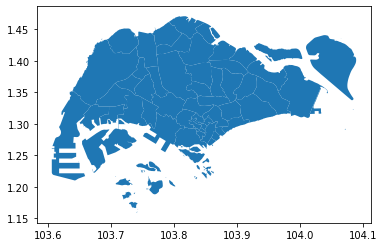

In [164]:
# see full map of singapore first
map_data['geometry'].plot()

Now we plot the price per square meter of flats against the towns they were built in:

<AxesSubplot:title={'center':'mean psqm'}>

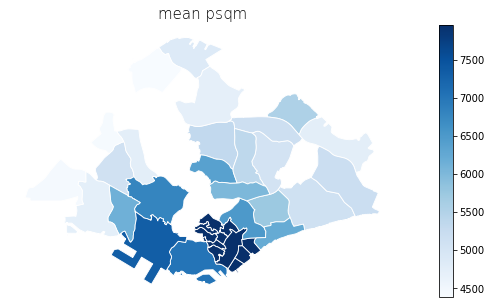

In [165]:
# price per sqm per town
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.axis('off')
ax.set_title('mean psqm', fontdict={'fontsize': '15', 'fontweight' : '3'})

summarize_towns_map.plot(column='price_per_sqm',
                        linewidth=0.9,
                        cmap='Blues',
                        ax=ax,
                        edgecolor='1',
                        legend=True, missing_kwds={
                        "color": "lightgrey",
                        "label": "Missing values"})

As discussed before, the most expensive place to live is the residential area in close proximity to CBD. This is the residential area labelled the Central Area (the one made up of 11 smaller regions that we had to replace in `map_data` earlier). You can see all the smaller 11 regions when looking at the regions with the darkest colour. 

The CBD is actually within the Central Area, so we can use that as a reference point for the location of the CBD in Singapore and consequently all other districts' proxmimity to the CBD.

For more curious readers, you will be able to interact with the map on my data source website linked earlier (https://data.gov.sg/datasets?formats=GEOJSON&sort=relevancy&page=1&resultId=d_4765db0e87b9c86336792efe8a1f7a66) if you want to know specifically which region is which. For the purposes of our analysis this detail in labels is not necessary as the key point is that the houses near the CBD are more expensive and houses further away are cheaper.

The CBD is also full of office buildings and generally lacks allowance for residential space, resulting in low floor area and high costs. We can also see that the further away we get from the CBD, the cheaper the price per sqm.

Next we go on to summarize flat types. Here we can better understand the type of housings that is popular and common amongst singaporeans.

In [166]:
# summarize flat types
summarize_flat_types = housing_data.groupby('flat_type').agg({"resale_price" : "mean",
                                                              "floor_area_sqm": "mean",
                                                              "price_per_sqm" : "mean",
                                                              "remaining_lease": "mean",
                                                              "month" : "count"})\
                                                        .reset_index()\
                                                        .rename(columns={'month': "num_of_sales"})
summarize_flat_types

,flat_type,resale_price,floor_area_sqm,price_per_sqm,remaining_lease,num_of_sales
0,1 ROOM,206461.567568,31.000000,6660.050567,53.382432,74
1,2 ROOM,283726.514016,45.771857,6219.827425,80.403525,3603
2,3 ROOM,357583.395023,68.144893,5259.241387,65.249521,46201
3,4 ROOM,507979.773308,95.031442,5379.817176,78.191788,82262
4,5 ROOM,603389.391278,117.719742,5143.946831,77.434353,48252
5,EXECUTIVE,709673.100135,144.825762,4896.845251,71.928763,14331
6,MULTI-GENERATION,842086.750000,161.137500,5243.237476,66.048750,80


Both resale price and floor area increase as the number of rooms in a house increase. I think that this is a pretty logical increase as you are paying for more area and more construction. However it surprised me to learn that actually, the price per sqm decreases as the floor area goes up.

It's also slightly shocking to see that less than 100 1-room and multi-generation flats were sold during 2017-2024, but this is more understandable as these are not common at all to begin with, and are actually being phased out over time.

We can see from the number of sales that the most common flats are 2/3/4-room flats, with 3-room flats being twice as popular as 2/4-room flats.

Given that price per sqm is a key focus on our analysis today, I wanted to do some exploration into how resale price is related to floor area. 

I plotted a scatter plot of resale price against floor area sqm and noticed something funny.

Text(0, 0.5, 'Resale Price')

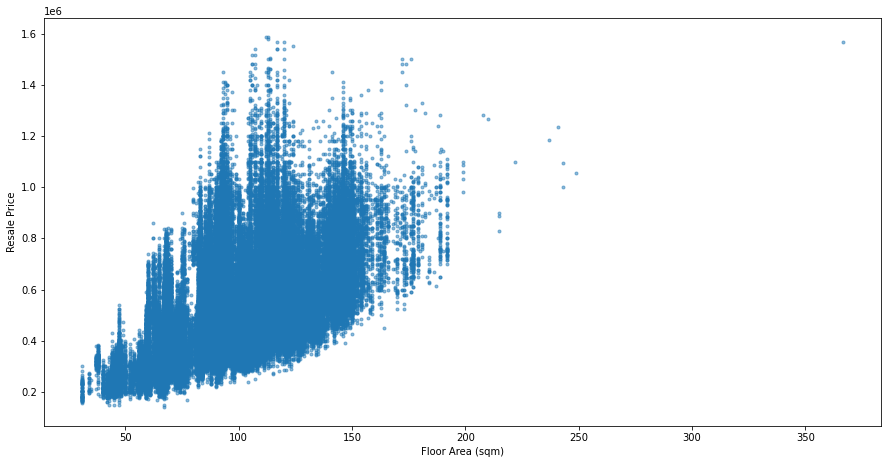

In [167]:
# price per floor_area_sqm (scatter plot)
fig, ax = plt.subplots(1, figsize=(15, 7.5))
plt.scatter(housing_data['floor_area_sqm'], housing_data['resale_price'], marker=".", alpha=0.5)
plt.xlabel ('Floor Area (sqm)')
plt.ylabel ('Resale Price')

There is a point that's an extreme outlier towards the top right of the plot!

To learn more about that point, we can filter for houses that have more than 350 sqm floor area.

In [168]:
# take a closer look at that point
housing_data[housing_data['floor_area_sqm']>350]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,geometry,resale_year,resale_month,resale_year_float,price_per_sqm
184425,2024-07-01,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,01 TO 03,366.7,Terrace,1972,47.0,1568000.0,None,2024,7,2024.5,4275.974911


This house appears to be a terrace house with 366.7 sqm of floor area and a resale price of $1.56m. Which may see expensive until you realise that `1,560,000 / 366.7 =` \$4245 per unit area. That's much actually lower than the average price per sqm and actually comparable to the 25% percentile (if you look back at the summary statistics of the dataset above).

Unfortunately just by looking online I was not able to find out why this house was more than twice the size of the other houses in the same block. This weekend, I'm planning on going to the area itself to see what's up with it, but until then, I will simply mark this point as an outlier and exclude it, so that it does not skew any further analysis.

Text(0, 0.5, 'Resale Price')

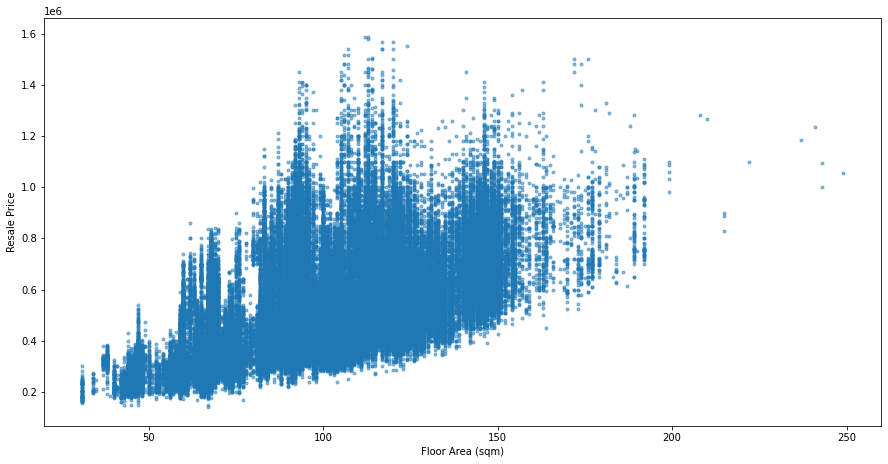

In [169]:
# price per floor_area_sqm (scatter plot) - without outlier
housing_data = housing_data[housing_data['floor_area_sqm']<350]
groups = housing_data.groupby('town')

fig, ax = plt.subplots(1, figsize=(15, 7.5))
plt.scatter(housing_data['floor_area_sqm'], housing_data['resale_price'], marker=".", alpha=0.5)
plt.xlabel ('Floor Area (sqm)')
plt.ylabel ('Resale Price')

Now that looks much better.

Finally, let's try to build a linear regression model to see how the resale price and price per sqm of public housing in Singapore has changed over time. As is with the current economy, we expect it to have increased over the years, but by how much?

To narrow our scope, we will also only be looking at 3-room flats.

Remember that we convert the resale year and month into a single floating point number in ['resale_year_float']. We can use this as our regression as it is a purely numerical variable.

Using the numpy `lstsq()` solver to do a simple linear regression, we can calculate the intercept and gradient of the best fit line through all our data points.

Best fit line gradient: [20530.17614213]
Best fit line intercept: [-41137320.41429695]


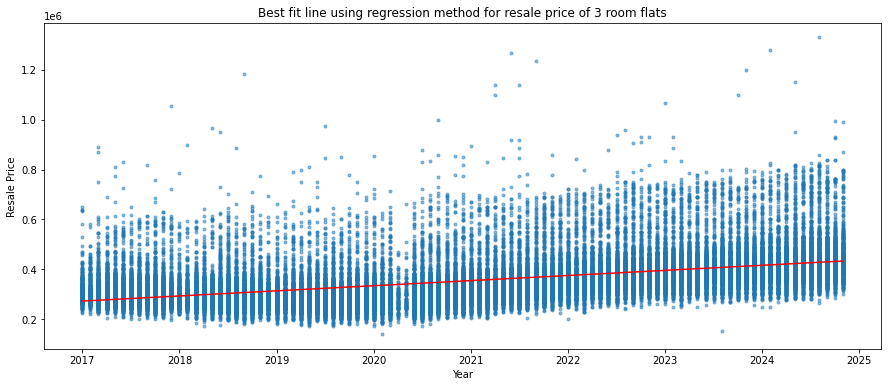

In [170]:
# rate of price increase of 3-room flats
dt = housing_data[housing_data['flat_type']=="3 ROOM"][["resale_year_float", "resale_price"]].to_numpy()

# Preparing X and y data from the given data
x = dt[:, 0].reshape(dt.shape[0], 1)
X = np.append(x, np.ones((dt.shape[0], 1)), axis=1)
y = dt[:, 1].reshape(dt.shape[0], 1)

# calculating the parameters using the least square method
m1, c1 = np.linalg.lstsq(X, y)[0]
print(f"Best fit line gradient: {m1}")
print(f"Best fit line intercept: {c1}")

# calculating the y-axis values against x-values according to
y_line = m1*x + c1



# Plotting the data points and the best fit line
fig, ax = plt.subplots(1, figsize=(15, 6))
plt.scatter(x, y, marker=".", alpha=0.5)
plt.plot(x, y_line, 'r')
plt.title('Best fit line using regression method for resale price of 3 room flats')
plt.xlabel('Year')
plt.ylabel('Resale Price')

plt.show()

Best fit line gradient: [304.65444043]
Best fit line intercept: [-610497.69097466]


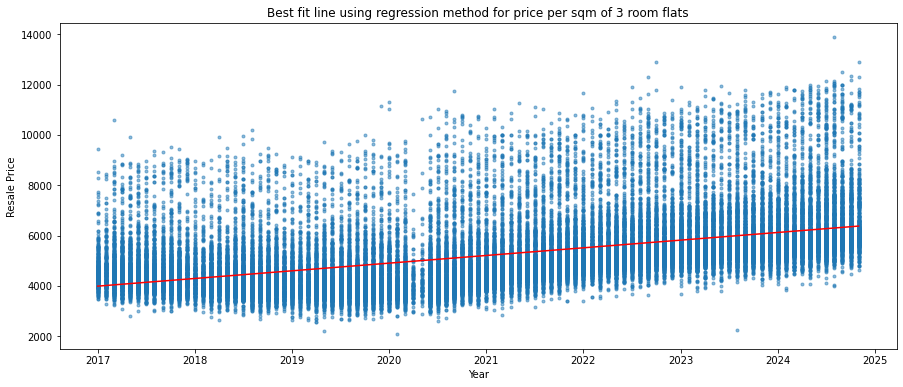

In [171]:
# rate of price_per_sqm increase of 3-room flats
dt = housing_data[housing_data['flat_type']=="3 ROOM"][["resale_year_float", "price_per_sqm"]].to_numpy()

# Preparing X and y data from the given data
x = dt[:, 0].reshape(dt.shape[0], 1)
X = np.append(x, np.ones((dt.shape[0], 1)), axis=1)
y = dt[:, 1].reshape(dt.shape[0], 1)

# alculating the parameters using the least square method
m2, c2 = np.linalg.lstsq(X, y)[0]
print(f"Best fit line gradient: {m2}")
print(f"Best fit line intercept: {c2}")

# calculating the y-axis values against x-values according to
y_line = m2*x + c2

# Plotting the data points and the best fit line
fig, ax = plt.subplots(1, figsize=(15, 6))
plt.scatter(x, y, marker=".", alpha=0.5)
plt.plot(x, y_line, 'r')
plt.title('Best fit line using regression method for price per sqm of 3 room flats')
plt.xlabel('Year')
plt.ylabel('Resale Price')

plt.show()

With the gradients from these best fit lines, we can see that the resale price of 3-room flats increase at about \$20k per year or \$304 per sqm per year.

(I just want to take a moment to point out the very noticeable decrease in sale numbers -- you can see by the density of the dots -- in the couple months slightly after 2020. This is about when COVID-19 would have affected Singapore, which noticeably affected housing sales!)

Now historically, the rate of inflation in Singapore has been about 2-3% (source: https://tradingeconomics.com/singapore/inflation-cpi). 

Let's calculate the rate that housing prices have been increasing in 2024.

In [172]:
# rate of increase of resale prices
y = m1*2024 + c1
rate_of_increase = round(float((m1/y) * 100),2)
print(f"Resale house prices are increasing at approximately {rate_of_increase}% per year in 2024.")

Resale house prices are increasing at approximately 4.94% per year in 2024.


In [173]:
# rate of increase of price per sqm
y = m2*2024 + c2
rate_of_increase = round(float((m2/y) * 100),2)
print(f"Price per sqm is increasing at approximately {rate_of_increase}% per year in 2024.")

Price per sqm is increasing at approximately 4.98% per year in 2024.


Both total resale price and price per sqm are increasing at about the same rate, and at a somewhat faster rate than the general inflation rate. After some research, it seems that this is to be expected (source: https://www.investopedia.com/ask/answers/correlation-inflation-houses.asp). 

Overall, it seems that the public housing market in Singapore is relatively stable, although not immune to the rising prices as is common in the rest of the world.

Going back to our original question: *has the price of public housing in Singapore really changed, and by how much?* Yes, it has changed, at about $20k per year for 3-room flats.

---

### Part 5
Observations and conclusions

In this project, we cleaned and analysed datasets of housing resale prices and geographical boundaries taken from Singapore's data.gov website.

We learned serveral things:
1. Resale prices and price per sqm are more expensive the closer you get to the city center
2. Although prices increase as the number of rooms increases, price per sqm actually decreases
3. There is a house on the record with a whopping 366sqm of floor area, it's unknown if this entry is a error in the system or if it's genuinely a really big house
4. Resale prices are increasing by about \$20k per year, or about \$304 per sqm per year
5. And these prices are increasing at a rate (~5%) slightly higher than the national inflation rate (~3%)

Some things we didnt account for:

Variations within districts: housing prices also vary depending on the facilities and amenities nearby. For example, a house with a train station nearby will cost more than a house without a train station nearby. Malls, schools, public transport all affect the price of a home as well. The data.gov.sg website also has locations of gyms, eating establishments, etc. that could be used in further analysis. Maybe there could be some exploration to see if the number of eating establishments in a district relates to the price of the houses within that district?

Limitations:

A simple linear regression is really too simple. There are a lot of factors that weren't taken into account when I modelled the data, such as location, storey and remaining lease.

Actually the problem of remaining lease is a pretty complicated one that I believe is somewhat unique to Singapore. You see, when you purchase public housing, you don't get to keep it forever. You're actually leasing it from the government for ~99 years (there are different number of years, but the most common is 99) and it goes back to the government after that with some exceptions. Thats what remaining lease means. Generally lower remaining lease means a lower price. 

Anyway. I think there is space for more exploration into the relationships between other variables. Maybe even instead of building the analysis based on price and time, we could build the analysis based on the number of sale and time. Are 3-room flats gaining or losing popularity over the years? What about how the number of houses sold per month? Is there a good month where prices are lower or the competition is lesser?

Another thing that I would like to do is a more complicated prediction model. Maybe with some time-series analysis I could get a more detailed understanding of the seasonality and trends within this data. It *is* a time-series data after all.

---